# <center> LEGO sets listing price prediction - regression model</center>

Machine Learning 1 Regression Project  
<b>Michał Thor, Bartłomiej Kowalczuk  </b>

In this project we wanted to conduct a regression analysis that would predict listing prices of LEGO toys based on 92 independent variables from the following dataset: https://www.kaggle.com/mterzolo/lego-sets.  

We used Linear Regression (using OLS), Linear Regression with selected features, Elastic Net regression and Multilayer Perceptron (Neural Network) and compared obtained results.


Firstly, we import all the necessary packages

In [229]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2_score

import keras
from keras import optimizers
from keras import regularizers
from keras import backend as K
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor

Nextly, we define some utillity functions that will help us in estimating/evaluating models.

We implement our own adjusted R-squared function, since sklearn package does not have one.

We also implement stepwise selection function for OLS model, which is based on the solution from:
https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn/24447#24447

Lastly we implement R-squared function for neural network improvement plotting.

In [230]:
def adj_r2(r_sqr, n, p):
    r_2 = 1-(1-r_sqr)*(n-1)/(n-p-1)
    return r_2


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.04, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# <center>1. Understanding the data</center>

### Loading the dataset

In [231]:
df = pd.read_csv('lego_Sets.csv')

### Brief preview of the dataset structure

In [232]:
display(df.head(5))

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_desc,prod_id,prod_long_desc,review_difficulty,set_name,star_rating,theme_name,val_star_rating,country
0,6-12,29.99,2.0,277.0,4.0,Catapult into action and take back the eggs fr...,75823.0,Use the staircase catapult to launch Red into ...,Average,Bird Island Egg Heist,4.5,Angry Birds™,4.0,US
1,6-12,19.99,2.0,168.0,4.0,Launch a flying attack and rescue the eggs fro...,75822.0,Pilot Pig has taken off from Bird Island with ...,Easy,Piggy Plane Attack,5.0,Angry Birds™,4.0,US
2,6-12,12.99,11.0,74.0,4.3,Chase the piggy with lightning-fast Chuck and ...,75821.0,Pitch speedy bird Chuck against the Piggy Car....,Easy,Piggy Car Escape,4.3,Angry Birds™,4.1,US
3,12+,99.99,23.0,1032.0,3.6,Explore the architecture of the United States ...,21030.0,Discover the architectural secrets of the icon...,Average,United States Capitol Building,4.6,Architecture,4.3,US
4,12+,79.99,14.0,744.0,3.2,Recreate the Solomon R. Guggenheim Museum® wit...,21035.0,Discover the architectural secrets of Frank Ll...,Challenging,Solomon R. Guggenheim Museum®,4.6,Architecture,4.1,US


Our goal is to predict value of the list_price variable - listing price of a certain toy in LEGO online store.

<b>country</b> variable is indicating which online store (from which country) is listing that item.

# <center>2. Preparing the dataset</center>

## 2.1 Removing useless data and fixing formats

Removing variables that would give no predictive power (information variables such as ID's or descriptions)

In [233]:
df = df.drop(['prod_desc', 
              'prod_id', 
              'prod_long_desc', 
              'set_name'],
             axis=1)

Changing categorical variables and list_price into right formats.

Also we are ordering review_difficulty since it is ordered scale of difficulty.

In [234]:
df.list_price = df.list_price.astype(float)
df['review_difficulty'] = df['review_difficulty'].astype("category")
df['review_difficulty'] = df['review_difficulty'].cat.reorder_categories(['Very Easy',
                                                               'Easy',
                                                               'Average',
                                                               'Challenging',
                                                               'Very Challenging'],
                                                                        ordered = True)
df['review_difficulty'] = df['review_difficulty'].cat.codes
df.theme_name = df.theme_name.astype(object)
df.ages = df.ages.astype(object)

## 2.2 Cleaning dataset from NA's

In [235]:
missing_data = pd.DataFrame({'Number of occurencies': df.isna().sum(),
                             'Percentage': 100*df.isna().sum()/len(df)
                            })
missing_data[missing_data['Number of occurencies'] > 0]

,Number of occurencies,Percentage
num_reviews,1620,13.212625
play_star_rating,1775,14.476796
star_rating,1620,13.212625
theme_name,3,0.024468
val_star_rating,1795,14.639915


Since the missings in star_rating (all 3 columns concerning them) are common for certain observations, maybe we can somehow reduce the number of them by filling missing values with computed value.

We mark the missings in review difficulty with a group code equal to -1.

We can see that star_rating has less NA's than play and val star_rating. We shall see if there is a correlation between those 3 variables. 

In [236]:
corr = df[['star_rating', 'play_star_rating', 'val_star_rating']].corr()
corr.style.background_gradient(cmap='coolwarm')

,star_rating,play_star_rating,val_star_rating
star_rating,1,0.608193,0.72789
play_star_rating,0.608193,1,0.480938
val_star_rating,0.72789,0.480938,1


Let us compute means of ratios between star_rating for the whole dataset and use that ratio to create values to impute instead of NA's.

Because of slightly high correlation we decide to omit star_rating and leave the two other ratings (and since they all have same number of NA's)

In [237]:
df['star/play'] = df['star_rating']/df['play_star_rating']
df['star/val'] = df['star_rating']/df['val_star_rating']

star_p_mean = df['star/play'].mean()
star_v_mean = df['star/val'].mean()

df.loc[(df['play_star_rating'].isnull()) & (df['star_rating'].notna()), "play_star_rating"] = df["star_rating"]*star_p_mean
df.loc[(df['val_star_rating'].isnull()) & (df['star_rating'].notna()), "val_star_rating"] = df["star_rating"]*star_v_mean

df.drop(['star/play', 'star/val', 'star_rating'], axis=1, inplace=True)

That way we manage to narrow our total rows with NA's to 1620. Unfortunately there is no way to safely replace values for these observations (which all have at least 3 NA's) so we will omit them in further analysis.

In [238]:
df.loc[df.isnull().sum(1)>=3].index

df = df.dropna()

## 2.3 Checking for correlations and encoding categorical variables - using One Hot Encoding

Creating correlation matrix:

In [239]:
corr = df.drop(['list_price'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,num_reviews,piece_count,play_star_rating,review_difficulty,val_star_rating
num_reviews,1,0.546616,-0.0451145,0.328073,0.0148351
piece_count,0.546616,1,0.0147979,0.509112,0.0636759
play_star_rating,-0.0451145,0.0147979,1,0.018671,0.499167
review_difficulty,0.328073,0.509112,0.018671,1,-0.00300082
val_star_rating,0.0148351,0.0636759,0.499167,-0.00300082,1


There are no visible very high correlations (some ~0.5, but we decide to leave them in further analysis, because these are not worrying values).

In [240]:
cat_vars = []
cont_vars = []
for variable in df.columns:
    if df[variable].dtype==object:
        cat_vars.append(variable)
    else:
        cont_vars.append(variable)
        
num_of_cats = {}
for category in cat_vars:
    num_of_cats[category] = len(list(df[category].unique()))
    
print(num_of_cats)

{'ages': 31, 'theme_name': 38, 'country': 21}


We can see that all the variables have a lot of levels, let's see how different are the numbers of observations within each level on barplots below.

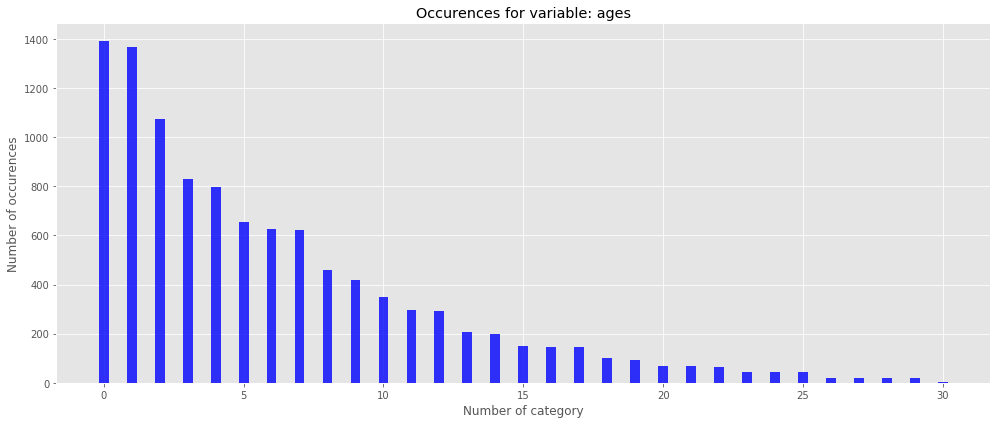

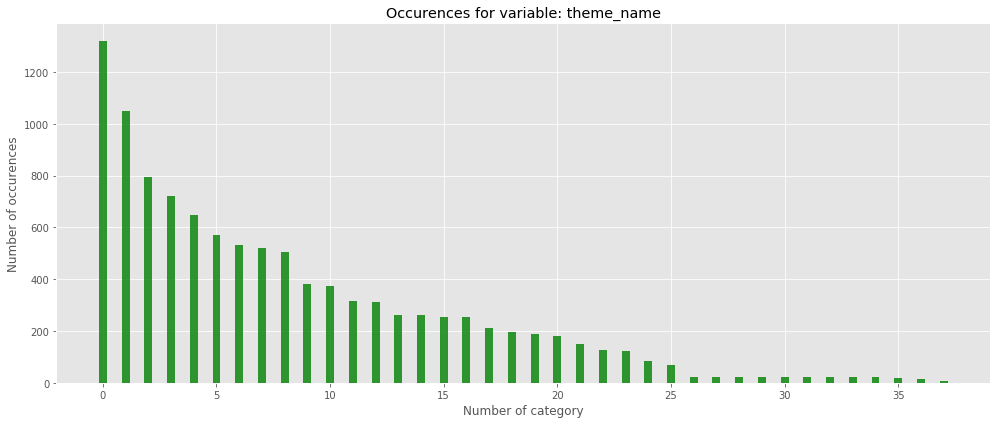

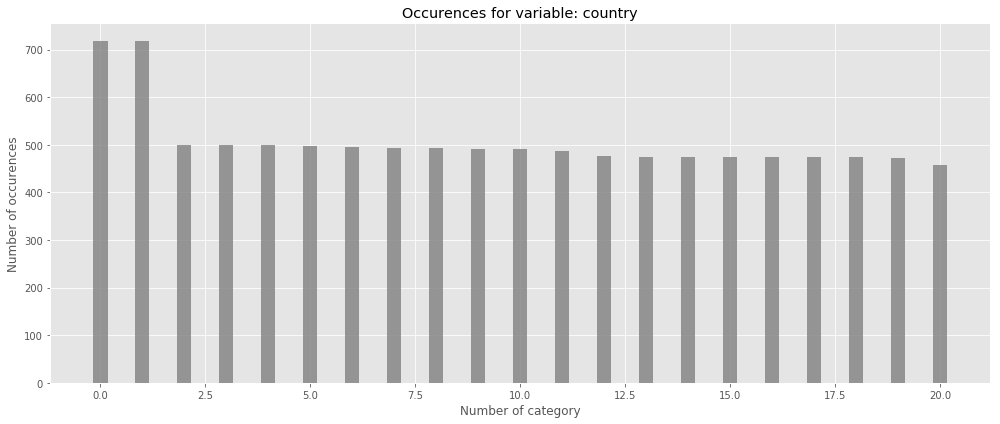

In [241]:
bar_width = 0.35
opacity = 0.8
colors = ["b","g","grey"]


for idx, var in enumerate(cat_vars):
    plt.figure(figsize=(14,6))
    boo = list(dict(df[var].value_counts()).values())
    leng = np.arange(len(list(dict(df[var].value_counts()).values())))
    rects = plt.bar(leng, boo, bar_width,
    alpha=opacity,
    color=colors[idx])
    plt.ylabel('Number of occurences')
    plt.xlabel('Number of category')
    plt.title('Occurences for variable: {}'.format(var))
    plt.tight_layout()
    plt.show()

Since there are no categories that would be very differently populated than the rest (they gradually descent) we decided to keep all the variables for one hot encoding.

Next we are creating dummy variables through one hot encoding for each category in categorical variables (omitting review_difficulty in which we introduced ordered categories).

In [242]:
df2 = pd.get_dummies(df, drop_first=True)

## 2.4 Splitting dataset into training and testing dataset

In [243]:
X, Y = df2.drop(['list_price'], axis=1), df2['list_price']

X_train, X_test, Y_train, Y_test = train_test_split(
                                                    X, 
                                                    Y, 
                                                    test_size=0.3, 
                                                    random_state=361)

In [244]:
df2.shape

(10638, 93)

We are left with 10638 observations and 92 variables which we have split into 70/30 train/test datasets. 

That way we are ready to begin estimating predictive models using 3 different methods.

# <center>3. Predicting data </center>

## 3.1 Linear Regression (OLS) model

Firstly, we are trying to estimate OLS linear regression model using all possible variables. We also add <i>constant</i> to the models equation.

In [245]:
X_train_lin = sm.add_constant(X_train)
X_test_lin = sm.add_constant(X_test)
 
ols_model = sm.OLS(Y_train, X_train_lin).fit()
linear_pred = ols_model.predict(X_test_lin) 

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             list_price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     533.6
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:18:04   Log-Likelihood:                -37322.
No. Observations:                7446   AIC:                         7.482e+04
Df Residuals:                    7357   BIC:                         7.544e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [247]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, linear_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, linear_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, linear_pred)))
print('Adjusted R-squared:', adj_r2(r2_score(Y_test, linear_pred), X_test_lin.shape[0], X_test_lin.shape[1]))

Mean Absolute Error: 16.757313097654322
Mean Squared Error: 1166.380221526104
Root Mean Squared Error: 34.15230916828471
Adjusted R-squared: 0.8630289709517912


We are using our own implementation of R-squared because we want to see value of the coefficient of determination on test data (by accessing <i>OLS.model.rsquared_adj</i> we get the value for training data). 

We can see promising values (although RMSE is quite high). There are some statistically insignificant variables, so we will now try to estimate model with only statistically significant features. Let us see how will the model with stepwise selected variables perform:

## 3.2 Linear Regression (OLS) model with stepwise selected features

During this stepwise selection, feature is included in the model if its p-value is lower than 0.05. Here we also add the <i>constant</i>.

In [248]:
selected_vars = stepwise_selection(X_train, Y_train, verbose=False)

stepwise_X_train = X_train[selected_vars]
stepwise_X_test = X_test[selected_vars]

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:48: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


In [249]:
stepwise_X_train = sm.add_constant(stepwise_X_train)
stepwise_X_test = sm.add_constant(stepwise_X_test)
 
stepwise_model = sm.OLS(Y_train, stepwise_X_train).fit()
stepwise_pred = stepwise_model.predict(stepwise_X_test) 

print(stepwise_model.summary())

                            OLS Regression Results                            
Dep. Variable:             list_price   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     1007.
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:20:26   Log-Likelihood:                -37455.
No. Observations:                7446   AIC:                         7.500e+04
Df Residuals:                    7400   BIC:                         7.532e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [250]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, stepwise_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, stepwise_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, stepwise_pred)))
print('Adjusted R-squared:', adj_r2(r2_score(Y_test, stepwise_pred), stepwise_X_test.shape[0], stepwise_X_test.shape[1]))

Mean Absolute Error: 17.47262645758098
Mean Squared Error: 1234.6376087891545
Root Mean Squared Error: 35.137410388205254
Adjusted R-squared: 0.8571346366590289


As we can see, obtained prediction metrics are worse than with OLS model build on the whole dataset. Since adjusted R-squared is lower for the restricted model, we know that the additional variables, which deemed statistically insignificant increase the accuracy (adjusted R-squared penalizes additional variables that bring no predictive power). 

How abount penalized regression, which should lower the variance for a little bias and give better predictions?

## 3.3 Elastic Net

Firstly, we are tuning the hyperparameters to find the best fit using 5 fold cross-validation with provided set of alphas, L1 and L2 penalties, margin of improvement for each iteration and whether we should normalize data or not.

In [251]:
# eNet = ElasticNet(max_iter = 100)

# parametersGrid = {"alpha": [0.0001, 0.001, 0.005, 0.01, 0.1, 1.0, 2.0, 10.0, 100.0, 300.0],
#                   "l1_ratio": np.arange(0.0, 1.0, 0.05),
#                  "tol": [0.000001, 0.00005, 0.00001, 0.0001, 0.01, 0.1],
#                  "normalize": [True, False]}

# grid = GridSearchCV(eNet, 
#                     parametersGrid, 
#                     scoring='neg_mean_squared_error', 
#                     cv=5,
#                     refit = 'neg_mean_squared_error')
# grid.fit(X_train, Y_train)
# grid_pred = grid.predict(X_test)
# print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Now, we estimate data using best parameters for elastic net.

In [252]:
eNet = ElasticNet(max_iter = 80000,
                  alpha = 0.0001,
                  l1_ratio = 0.95,
                  tol = 0.0000001,
                 normalize = False)

eNet.fit(X_train, Y_train)
elastic_pred = eNet.predict(X_test)

In [254]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, elastic_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, elastic_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, elastic_pred)))
print('Adjusted R-squared:', adj_r2(r2_score(Y_test, elastic_pred), X_test.shape[0], X_test.shape[1]))

Mean Absolute Error: 16.746761117586374
Mean Squared Error: 1167.1341440449467
Root Mean Squared Error: 34.16334503594381
Adjusted R-squared: 0.8629846629209051


We can see that results are still not as good as when using simple Linear Regression. Penalized regression such as Elastic Net should lower the variance compared to OLS model in favor of a little bias to avoid overfitting and therefore to make more accurate predictions. However, the predictive ability on the test data proved to be worse than for OLS model - that is quite unexpected.

## 3.4 Neural Network

Finally, we are trying to use sequential neural network with 3 hidden layers, for which we shall firstly tune the hyperparameters - we are using 5 fold cross-validation for that purpose with provided values of parameters to choose from. 

We strongly suggest <b>NOT RUNNING</b> this part of code which is commented, because it takes few hours on a decent machine (if it does not Memory bloat - run out of RAM memory).

Here is a logger file, which will help us plot improvements over time of trained neural network.

In [255]:
csv_logger = CSVLogger('neural.log', separator=',', append=False)

In [256]:
def create_model(momentum = 0.2,
                activation = 'softplus',
                learn_rate = 0.001,
                dropout_rate = 0.0,
                weight_constraint = 3,
                neurons = 75,
                init = 'glorot_uniform',
                optimizer = 'adagrad',
                normalize = True): 

    # create model
    NN_model = Sequential()
    NN_model.add(Dense(128, 
                   kernel_initializer=init,
                   input_dim = X_train.shape[1], 
                   activation=activation))

    # The Hidden Layers :
    NN_model.add(Dense(neurons, 
                       kernel_initializer=init,
                       activation=activation,
                      kernel_constraint=maxnorm(weight_constraint)))
    NN_model.add(Dense(neurons, 
                       kernel_initializer=init,
                       activation=activation,
                      kernel_constraint=maxnorm(weight_constraint)))
    NN_model.add(Dropout(dropout_rate)) 
    NN_model.add(Dense(neurons, 
                       kernel_initializer=init,
                       activation=activation,
                      kernel_constraint=maxnorm(weight_constraint)))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer=init,
                       activation='linear'))

    
    NN_model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['mean_absolute_error',
                           'mean_squared_error',
                          r2_keras])
    
    NN_model.fit(X_train, 
                 Y_train,
                 epochs=350,
                 batch_size=64,
                 callbacks=[csv_logger])
    
    return NN_model


model = KerasRegressor(build_fn=create_model, 
                        epochs = 50, 
                        batch_size = 64,
                        verbose = 1)

In [257]:
# def grid_search(model = model):
# # Use scikit-learn to grid search 
#     activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
#     momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#     learn_rate = [0.0001, 0.0005, 0.001, 0.025, 0.005, 0.075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2]
#     dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#     weight_constraint=[1, 2, 3, 4, 5]
#     neurons = [30, 64, 75, 100, 128, 200, 256]
#     init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
#     optimizer = ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']
#     normalize = [True, False]
#     ##############################################################
#     # grid search epochs, batch size
#     epochs = [50, 100] # add 50, 100, 150 etc
#     batch_size = [10, 32, 64, 100] # add 5, 10, 20, 40, 60, 80, 100 etc
#     param_grid = dict(# epochs=epochs,
# #                      batch_size=batch_size,
# #                      activation=activation,
# #                      momentum=momentum,
# #                      learn_rate=learn_rate,
# #                      dropout_rate=dropout_rate,
# #                      weight_constraint=weight_constraint,
# #                      neurons=neurons,
# #                      init=init,
# #                      optimizer=optimizer,
# #                      normalize=normalize
#                      )
#     ##############################################################
#     grid = GridSearchCV(estimator=model, 
#                         param_grid=param_grid, 
#                         scoring=['r2'],
#                         refit = 'r2',
#                         n_jobs=1,
#                         cv = 2)
#     grid_result = grid.fit(X_train, Y_train) 
#     ##############################################################
#     # summarize results
#     print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#     means = grid_result.cv_results_['mean_test_r2']
#     stds = grid_result.cv_results_['std_test_r2']
#     params = grid_result.cv_results_['params']
#     for mean, stdev, param in zip(means, stds, params):
#         print("%f (%f) with: %r" % (mean, stdev, param))
        
# grid_search(model)

After cross-validated tuning we choose those parameters:

- <b>Number of epochs</b> = 350

- <b>Batch sizes</b> = 64

- <b>Activation function</b> = Softplus, which for <i>x</i> is <i>log(exp(x) + 1)</i>

- <b>Learning rate</b> = 0.001 - it determines how quickly model is adapted to the prob- lem (using stochastic gradient descent)

- <b>Dropout rate</b> = 0, because there was too much data lost when droping some inputs-

- <b>Weight constraint</b> = 3, preventing model from using too big weights and therefore overfitting,

- <b>Number of neurons per layer</b> = 75

- <b>Initializer</b> = Glorot uniform initializer, also called Xavier uniform initializer

- <b>Optimizer</b> = Adagrad, which is an optimizer with parameter-specific learning rates, which are adapted relative to how frequently a parameter gets updated during training

- <b>Normalize the data</b> = True,

for which cross-validation proved that model have value of R-Squared =~ 0.97. 

Here we are creating the model with chosen parameters and saving it into a file (the best model is already saved and will be loaded below).

In [258]:
# neural_network = create_model()

# neural_network.save("lego_neural.h5")

Here we load the model and logged history of training and predict the dependent variable.

In [259]:
neural_network = load_model("lego_neural.h5", custom_objects={'r2_keras': r2_keras})
log_data = pd.read_csv('neural.log', sep=',', engine='python')
neural_pred = neural_network.predict(X_test)

In [260]:
mae = log_data['mean_absolute_error']
mse = log_data['mean_squared_error']
r_2 = log_data['r2_keras']
epochs = range(len(mae))

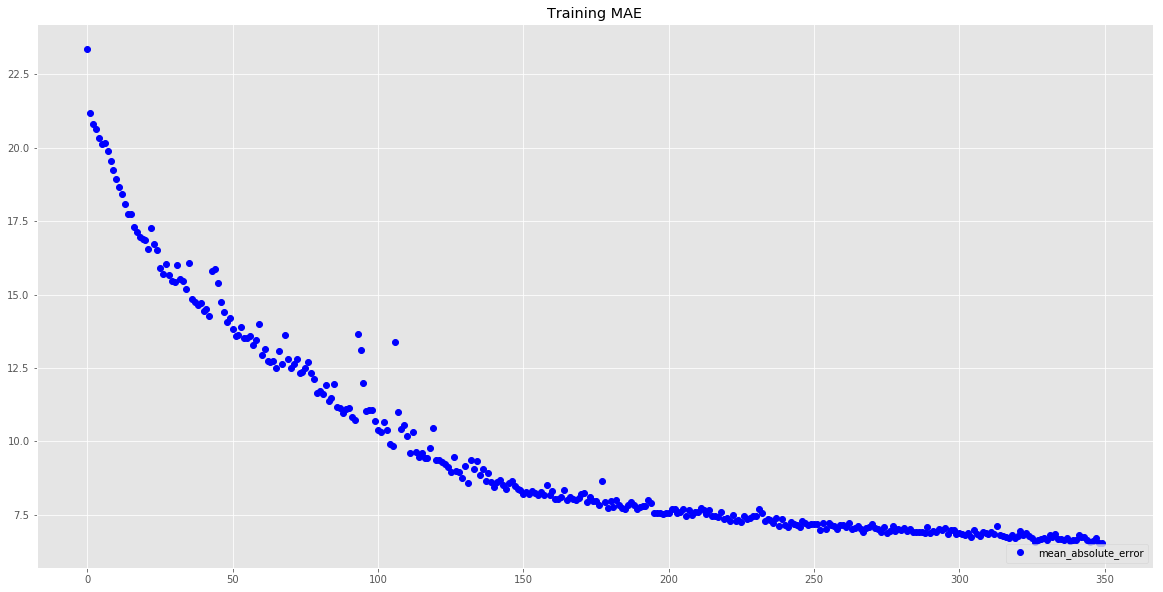

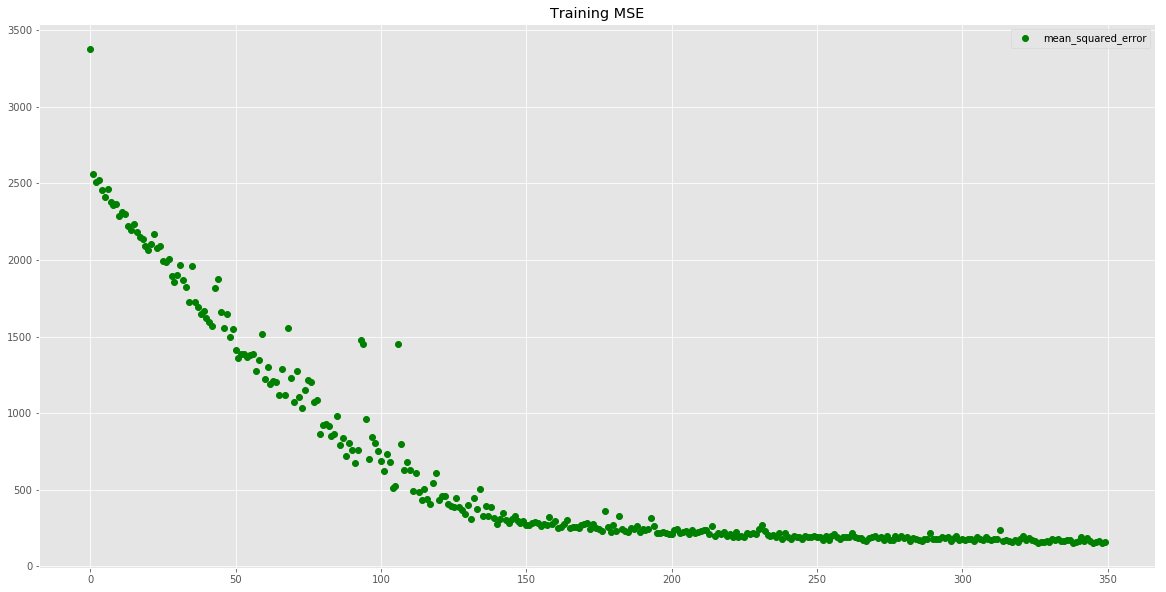

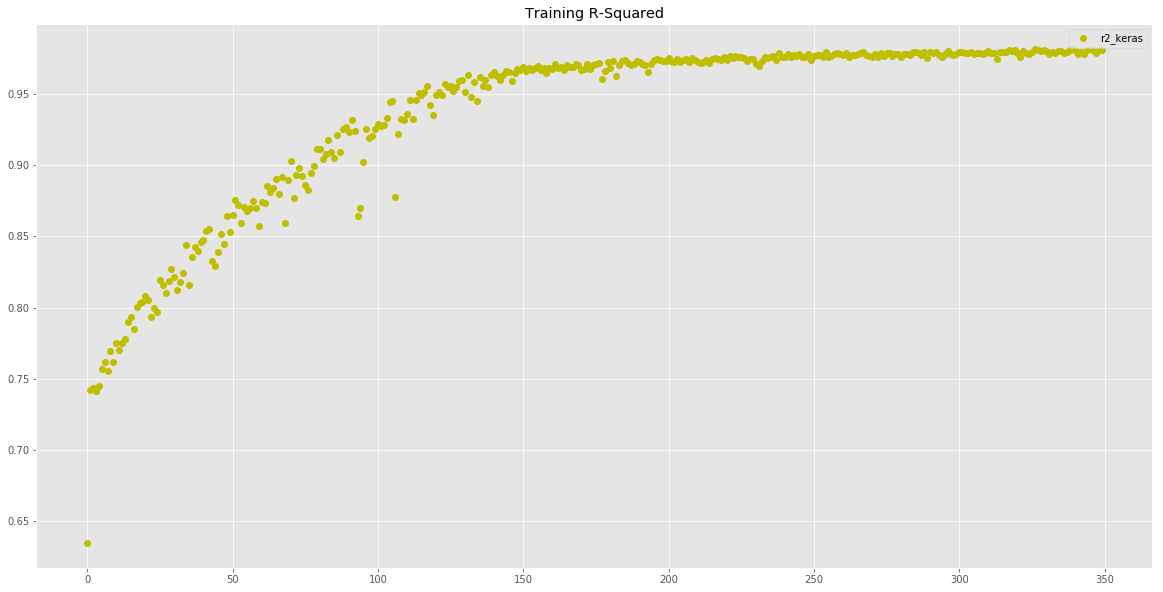

In [261]:
# accuracy
plt.figure(figsize=(20,10))
plt.style.use('ggplot')
plt.plot(epochs, mae, 'bo')
plt.title('Training MAE')
plt.legend(loc='lower right')
plt.show()

# loss
plt.figure(figsize=(20,10))
plt.plot(epochs, mse, 'go')
plt.title('Training MSE')
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(epochs, r_2, 'yo')
plt.title('Training R-Squared')
plt.legend()
plt.show()

As we can see on the plots above, all the metrics were improving over the time, however very significant improvements stopped after around 200th epoch.

In [262]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, neural_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, neural_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, neural_pred)))
print('Adjusted R-squared:', adj_r2(r2_score(Y_test, neural_pred), X_test.shape[0], X_test.shape[1]))

Mean Absolute Error: 6.51161103141756
Mean Squared Error: 136.86394224702045
Root Mean Squared Error: 11.698886367813838
Adjusted R-squared: 0.9839329015635181


We can see that results for test data are far better for neural network - adjusted R-squared of ~0.98 gives us almost a perfect fit - with MAE of ~7$. And we can see that there is no overfitting - as we were expecting because of cross-validation which predicted similar forecasts.

# <center>4. Comparison</center>

Since there are a lot of metrics to measure regression accuracy we focused on 3:
MAE - Mean Absolute Error
RMSE - Root Mean Squared Error
AdjR - Adjusted R-Squared

RMSE and MAE do not actually tell how good is the model - they allow us to compare models in their predictive ability. There is however, interpretation of MAE if our dependant variable is interpretable - such as listing price in our case. 

We add RMSE, because it penalizes higher differences between real data and predicted harder than MAE. 

We also use Adjusted R-Squared to get absolute (not relative) information about how good model actually is.

In [273]:
pred_list = [linear_pred, stepwise_pred, elastic_pred, neural_pred]

stat_list = []

for pred in pred_list:
    mae = float(format(metrics.mean_absolute_error(Y_test, pred), '.4f'))
    rmse = float(format(np.sqrt(metrics.mean_squared_error(Y_test, pred)), '.4f'))
    if pred.all() == stepwise_pred.all():
        adjr2 = float(format(adj_r2(r2_score(Y_test, pred), stepwise_X_test.shape[0], stepwise_X_test.shape[1]), '.4f'))
    else:
        adjr2 = float(format(adj_r2(r2_score(Y_test, pred), X_test.shape[0], X_test.shape[1]), '.4f'))
    stat_list.append([mae,rmse,adjr2])
    
stat_df = pd.DataFrame(stat_list)
stat_df.rename(columns={0 : "Mean Absolute Error", 1 : "Root Mean Squared Error", 2 : "Adjusted R-Squared"}, 
                 index={ 0 : "OLS", 1 : "Restricted OLS" , 2 : "Elastic Net" , 3 : "Neural Network" }, 
                 inplace=True)

stat_df.style.apply(lambda x: ['font-weight: bold' if x.name == "Neural Network" else '' for i in x], axis=1)

,Mean Absolute Error,Root Mean Squared Error,Adjusted R-Squared
OLS,16.7573,34.1523,0.865
Restricted OLS,17.4726,35.1374,0.8571
Elastic Net,16.7468,34.1633,0.8649
Neural Network,6.5116,11.6989,0.9842


We can clearly see that prediction errors and overall accuracy of the model (Adjusted R-Squared) are far superior for the Neural Network model. It was expectable, as they are the most sophisticated of the methods used above.

# <center>5. Conclusion</center>

In the analysis conducted above we compared 4 methods (3 actually, one with just changed features) to see which one will work the best in predicting continous variable. 

Obviously, first choice was Linear Regression, which proved to be second most accurate, even beating Elastic Net. However we suspect that on larger dataset its' performance would fall significantly.

Linear Regression with restricted features, to our surprise, gave worst results. More thorough analysis of stepwise selection function and/or dataset would maybe improve the result but for now its' performance is not satisfying.

Elastic Net, our third approach, gave lower MAE than OLS but it performed worse considering RMSE and Adjusted R-Squared. One of the reasons may be that Elastic Net, because it is designed to penalize high variance and therefore overfitting, estimates too general model, which in our case gives worse predictive values than OLS. Just as we suspect Linear Regression to fall with larger datasets, we would think that Elastic Net might retain similar predictive ability.

Last method we used was Neural Network - it showed outstanding predictions with over 2x lower MAE and Adjusted R-Squared of almost 1.0 proving that it is a superior regression tool. Only one thing remain - interpretability of coefficients. In Neural Network there are none, therefore it is very hard to draw conclusions. In furhter analysis we could run random forest on predicted (by Neural Network) values and try to find what variables are the most impactful and in what way, but this is in no way as accurate as OLS interpretation. 

And our hope is that we proved to some point why no regression method is perfect.